In [1]:
import sys
from datetime import datetime
sys.path.append('../')

# Custom print class
from CustomPrint import CustomPrint
print_ = CustomPrint()

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

# ML algo
from RegressionLogistic import LogisticRegressionCustom
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# CV split
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import log_loss, roc_curve, auc
from scipy import stats

### Load dataset

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

### Let's check some baseline scores

In [3]:
y_true = df_train['target'].values

y_hat = np.random.uniform(0, 1, len(y_true))
print('logloss with y_true and random predictions\t\t{:.3f}'.format(log_loss(y_true, y_hat)))

y_hat[:] = 0.5
print('logloss with y_true and 0.5 predictions\t\t\t{:.3f}'.format(log_loss(y_true, y_hat)))

y_hat[:] = y_true.mean()
print('logloss with y_true and target mean predictions\t\t{:.3f}'.format(log_loss(y_true, y_hat)))

logloss with y_true and random predictions		0.999
logloss with y_true and 0.5 predictions			0.693
logloss with y_true and target mean predictions		0.550


*** We manage to get 0.55 logloss without any machine learning ***<br />
*** Can we do better ? ***

###  Very simple processing of the data

In [4]:
id_train = df_train['ID'].values
id_test = df_test['ID'].values

# drop v22 and v107
df_train.drop(['ID', 'v22', 'v107'], 1, inplace=True)
df_test.drop(['ID', 'v22', 'v107'], 1, inplace=True)

# let's one-hot encode all the categorical values
# we need to concat df_train and df_test because if one value doesn't appear in the other one, we going to have different columns
df = pd.concat([df_train, df_test]).reset_index(drop=True)

# to make this more simple, we impute all NaNs values with -1
df.fillna(-1, inplace=True)

# you need to save memory, let's go sparse !
df = pd.get_dummies(df, sparse=True)

df_train = df[df['target'] >= 0].copy()
df_test = df[df['target'] == -1].copy()

df_train.drop(['target'], 1, inplace=True)
df_test.drop(['target'], 1, inplace=True)

del df

print('Shape df_train : {}, {}'.format(*df_train.shape))
print('Shape df_test : {}, {}'.format(*df_test.shape))

Shape df_train : 114321, 490
Shape df_test : 114393, 490


# Let's do some Machine Learning

In [5]:
def make_submit(name, id_test, preds, score, date, header='ID,PredictedProb'):
    """
        Function to create sumbit file for Kaggle competition
    """
    ID, TARGET = header.split(',')
    df_submit = pd.DataFrame({ID: id_test, TARGET: preds})
    file_name = "./submit_{}_{}_{:.5f}.csv".format(name, date, score)
    df_submit.to_csv(file_name, index=False)

In [6]:
def scikit_train(algo_to_use, df_train, df_test, y_true, splits):
    start_model = datetime.now()

    scores_train = []
    scores_cv = []

    # stacking
    y_full_train = np.zeros((df_train.shape[0], 1))
    y_test_hat = np.zeros((df_test.shape[0], n_folds))

    for fold, (train_index, cv_index) in enumerate(splits):

        y_train, y_cv = y_true[train_index], y_true[cv_index]
        X_train, X_cv = df_train.loc[train_index].values, df_train.loc[cv_index].values

        X_test = df_test.values

        start_training = datetime.now()
        model = algo_to_use
        model.fit(X_train, y_train)
        end_training = datetime.now()

        y_train_hat = model.predict_proba(X_train)[:,1]
        y_cv_hat = model.predict_proba(X_cv)[:,1]
        y_test_hat[:, fold] = model.predict_proba(X_test)[:,1]

        # filling train stacking dataset
        y_full_train[cv_index, :] = y_cv_hat.reshape(-1, 1)

        scores_train.append(log_loss(y_train, y_train_hat))
        scores_cv.append(log_loss(y_cv, y_cv_hat))

        print_.score(fold, scores_train[fold], scores_cv[fold], start_training, end_training)
    end_model = datetime.now()
    print_.score('', np.mean(scores_train), np.mean(scores_cv), start_model, end_model)

    name = model.__class__.__name__

    # make submit
    preds = y_test_hat.mean(axis=1)
    score = np.mean(scores_cv)
    date = datetime.now().strftime("%Y.%m.%d")
    make_submit(name, id_test, preds, score, date)
    
    return y_full_train, y_test_hat

def xgboost_train(params, df_train, df_test, y_true, splits):
    start_model = datetime.now()

    scores_train = []
    scores_cv = []

    # stacking
    y_full_train = np.zeros((df_train.shape[0], 1))
    y_test_hat = np.zeros((df_test.shape[0], n_folds))

    for fold, (train_index, cv_index) in enumerate(splits):

        y_train, y_cv = y_true[train_index], y_true[cv_index]
        X_train, X_cv = df_train.loc[train_index].values, df_train.loc[cv_index].values

        X_test = df_test.values

        dtrain = xgb.DMatrix(X_train, y_train, missing=-1)
        dcv = xgb.DMatrix(X_cv, y_cv, missing=-1)
        dtest = xgb.DMatrix(X_test, missing=-1)

        start_training = datetime.now()

        booster = {
            'num_boost_round': 20000, 
            'early_stopping_rounds': 10,
            'evals': [(dtrain, 'train'), (dcv, 'cv')],
            'verbose_eval': None,
        }

        model = xgb.train(params, dtrain, **booster)

        end_training = datetime.now()

        y_train_hat = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
        y_cv_hat = model.predict(dcv, ntree_limit=model.best_ntree_limit)
        y_test_hat[:, fold] = model.predict(dtest, ntree_limit=model.best_ntree_limit)

        # filling train stacking dataset
        y_full_train[cv_index, :] = y_cv_hat.reshape(-1, 1)

        scores_train.append(log_loss(y_train, y_train_hat))
        scores_cv.append(log_loss(y_cv, y_cv_hat))

        print_.score(fold, scores_train[fold], scores_cv[fold], start_training, end_training)
    end_model = datetime.now()
    print_.score('', np.mean(scores_train), np.mean(scores_cv), start_model, end_model)

    name = 'XGBoostClassifier'

    # make submit
    preds = y_test_hat.mean(axis=1)
    score = np.mean(scores_cv)
    date = datetime.now().strftime("%Y.%m.%d")
    make_submit(name, id_test, preds, score, date)
    
    return y_full_train, y_test_hat

### Make some splits for Cross-validation

In [7]:
n_folds = 3
suffle = True
seed = 314159

skf = StratifiedKFold(n_splits=n_folds, shuffle=suffle, random_state=seed)
splits = list(skf.split(df_train, y_true))

### Train Level 1 Models and create Leval 2 dataset

In [9]:
df_train_L2 = pd.DataFrame()
df_test_L2 = pd.DataFrame()

#########################
## Logistic Regression ##
#########################
print('\nLogisticRegression')
model = LogisticRegressionCustom(fit_intercept=True)
y_full_train, y_test_hat = scikit_train(model, df_train, df_test, y_true, splits)

# Fill L2 Dataset
df_train_L2['LogisticRegression'] = y_full_train.flatten()
df_test_L2['LogisticRegression'] = y_test_hat.mean(axis=1).flatten()


###################
## Random Forest ##
###################
print('\nRandomForestClassifier')
model = RandomForestClassifier(n_estimators=150, n_jobs=-1)
y_full_train, y_test_hat = scikit_train(model, df_train, df_test, y_true, splits)

# Fill L2 Dataset
df_train_L2['RandomForestClassifier'] = y_full_train.flatten()
df_test_L2['RandomForestClassifier'] = y_test_hat.mean(axis=1).flatten()


#############
## XGBoost ##
#############
print('\nXGBoostClassifier')

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'subsample': 0.7,
    'colsample_bytree': 0.5,
    'silent': 1,
}

y_full_train, y_test_hat = xgboost_train(params, df_train, df_test, y_true, splits)

# Fill L2 Dataset
df_train_L2['XGBoostClassifier'] = y_full_train.flatten()
df_test_L2['XGBoostClassifier'] = y_test_hat.mean(axis=1).flatten()


LogisticRegression
-------------------------------------------------------------------------------------------
|     FOLD     |    TRAIN     |      CV      |    START     |     END      |     DUR      |
-------------------------------------------------------------------------------------------
|      0       |   0.47884    |   0.48504    |   09:25:52   |   09:26:53   |   00:01:01   |
|      1       |   0.47873    |   0.48510    |   09:26:58   |   09:28:13   |   00:01:14   |
|      2       |   0.48035    |   0.48167    |   09:28:19   |   09:29:12   |   00:00:53   |
-------------------------------------------------------------------------------------------
|              |   0.47931    |   0.48394    |   09:25:48   |   09:29:12   |   00:03:24   |
-------------------------------------------------------------------------------------------

RandomForestClassifier
-------------------------------------------------------------------------------------------
|     FOLD     |    TRAIN     |     

### How the dataset from L1 models looks like

In [10]:
df_train_L2.head()

,LogisticRegression,RandomForestClassifier,XGBoostClassifier
0,0.814681,0.760000,0.861056
1,0.692432,0.693333,0.664703
2,0.820489,0.740000,0.810790
3,0.936762,0.920000,0.957116
4,0.877795,0.966667,0.920223


In [11]:
df_test_L2.head()

,LogisticRegression,RandomForestClassifier,XGBoostClassifier
0,0.454072,0.451111,0.229568
1,0.907662,0.751111,0.882014
2,0.717293,0.733333,0.726329
3,0.579556,0.451111,0.597525
4,0.702669,0.742222,0.763547


In [12]:
df_train_L2.corr()

,LogisticRegression,RandomForestClassifier,XGBoostClassifier
LogisticRegression,1.000000,0.785884,0.873725
RandomForestClassifier,0.785884,1.000000,0.845362
XGBoostClassifier,0.873725,0.845362,1.000000


# Let's train model with L2 dataset

In [14]:
df_train_L3 = pd.DataFrame()
df_test_L3 = pd.DataFrame()

# This dataset is prone to overfiting so we update parameters for XGBoost and RandomForest accordingly

## Logistic Regression
model = LogisticRegressionCustom(fit_intercept=True)
y_full_train, y_test_hat = scikit_train(model, df_train_L2, df_test_L2, y_true, splits)

# Fill L3 Dataset
df_train_L3['LogisticRegression'] = y_full_train.flatten()
df_test_L3['LogisticRegression'] = y_test_hat.mean(axis=1).flatten()

## Random Forest
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, min_samples_split=40, min_samples_leaf=30, max_leaf_nodes=30)
y_full_train, y_test_hat = scikit_train(model, df_train_L2, df_test_L2, y_true, splits)

# Fill L3 Dataset
df_train_L3['RandomForestClassifier'] = y_full_train.flatten()
df_test_L3['RandomForestClassifier'] = y_test_hat.mean(axis=1).flatten()

## XGBoost

params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'subsample': 0.5,
    'silent': 1,
}

y_full_train, y_test_hat = xgboost_train(params, df_train_L2, df_test_L2, y_true, splits)

# Fill L3 Dataset
df_train_L3['XGBoostClassifier'] = y_full_train.flatten()
df_test_L3['XGBoostClassifier'] = y_test_hat.mean(axis=1).flatten()

-------------------------------------------------------------------------------------------
|     FOLD     |    TRAIN     |      CV      |    START     |     END      |     DUR      |
-------------------------------------------------------------------------------------------
|      0       |   0.46472    |   0.46717    |   09:36:43   |   09:36:43   |   00:00:00   |
|      1       |   0.46527    |   0.46605    |   09:36:43   |   09:36:43   |   00:00:00   |
|      2       |   0.46655    |   0.46355    |   09:36:43   |   09:36:43   |   00:00:00   |
-------------------------------------------------------------------------------------------
|              |   0.46552    |   0.46559    |   09:36:43   |   09:36:43   |   00:00:00   |
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
|     FOLD     |    TRAIN     |      CV      |    START     |     END      |    

In [15]:
df_train_L3.head()

,LogisticRegression,RandomForestClassifier,XGBoostClassifier
0,0.847433,0.829492,0.811947
1,0.699621,0.685966,0.688679
2,0.815262,0.796500,0.753188
3,0.929139,0.955298,0.971455
4,0.928763,0.935657,0.961307


In [16]:
df_train_L3.corr()

,LogisticRegression,RandomForestClassifier,XGBoostClassifier
LogisticRegression,1.000000,0.981501,0.97039
RandomForestClassifier,0.981501,1.000000,0.99033
XGBoostClassifier,0.970390,0.990330,1.00000


### Make an average of all the predictions

We are going to use Nelder-Mead optimization algorithm to find the best weights for : $w_1X_1^{w_2} + w_3X_2^{w_4} + w_4X_3^{w_5} + w_6$
avec :

$X_1$ : probabilities for RegLog

$X_2$ : probabilities for RandfomForest

$X_3$ : probabilities for Xgboost

In [19]:
## The score should be around 0.460 if it is note the case, re-initialize the weights and re-run the minimization

from scipy.optimize import minimize

def f(weights):
    y_hat = df_train_L3.pow(weights[0:3]).dot(weights[3:6]) + weights[6]
    return log_loss(y_true, y_hat)

weights = np.random.uniform(0, 1, 7)
best_weights = minimize(f, weights, method='Nelder-Mead')

print('weights : {3:.2f}*RegLog^{0:.2f} + {4:.2f}*RF^{1:.2f} + {5:.2f}*XGB^{2:.2f} + {6:.2f}'.format(*best_weights['x']))

w = best_weights['x']

y_train_hat = (df_train_L3.pow(w[0:3]).dot(w[3:6]) + w[6]).values
stack_score = log_loss(y_true, y_train_hat)
print('Stack RegLog RF XGB logloss score final score  : {:.5f}'.format(stack_score))

# make submit
name = "Stack_RegLog_RF_XGB"
preds = df_test_L3.pow(w[0:3]).dot(w[3:6]) + w[6]
date = datetime.now().strftime("%Y.%m.%d")
make_submit(name, id_test, preds, stack_score, date)

weights : 1.38*RegLog^0.05 + 0.25*RF^1.95 + 0.60*XGB^0.88 + -1.23
Stack RegLog RF XGB logloss score final score  : 0.46072


# Let's go beyond probabilities

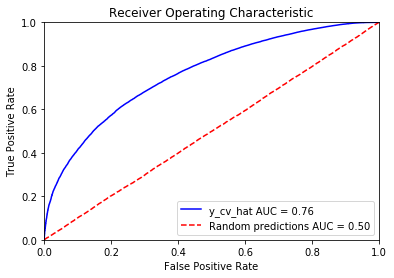

In [20]:
y_alea = np.ones(len(y_true))
y_alea[:] = np.random.uniform(0, 1, len(y_true))

alea_fpr, alea_tpr, threshold = roc_curve(y_true, y_alea)
alea_roc_auc = auc(alea_fpr, alea_tpr)

fpr, tpr, threshold = roc_curve(y_true, y_train_hat)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'y_cv_hat AUC = %0.2f' % roc_auc)
plt.plot(alea_fpr, alea_tpr, 'r--', label = 'Random predictions AUC = %0.2f' % alea_roc_auc)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Let's opitmize the recall and the precision ( /!\ precision is not the accuracy )

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in long_scalars


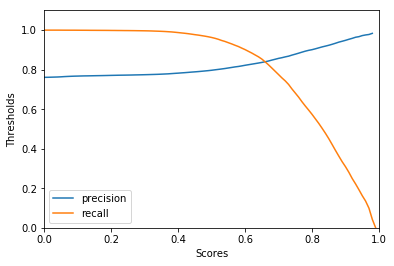

In [21]:
def precision(y_true, y_hat):
    tp = ((y_true == 1) & (y_hat == 1)).sum()
    fp = ((y_true == 0) & (y_hat == 1)).sum()
    return tp / (tp + fp)

def recall(y_true, y_hat):
    tp = ((y_true == 1) & (y_hat == 1)).sum()
    fn = ((y_true == 1) & (y_hat == 0)).sum()
    return tp / (tp + fn)

thresholds = np.arange(0, 1, 0.01)

best_precision = dict()
for th in thresholds:
    best_precision[th] = precision(y_true, y_train_hat > th)
    
best_recall = dict()
for th in thresholds:
    best_recall[th] = recall(y_true, y_train_hat > th)

plt.plot(thresholds, list(best_precision.values()), label='precision')
plt.plot(thresholds, list(best_recall.values()), label='recall')
plt.legend(loc = 'lower left')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('Thresholds')
plt.xlabel('Scores')
plt.show()

In [30]:
intersection = []
for x, y in list(zip(best_precision.values(), best_recall.values())):
    if not np.isnan(x) and not np.isnan(y):
        intersection.append(abs(x-y))
best_threshold = thresholds[np.argmin(intersection)]
print('The threshold who gives the best recal and precision is : {}'.format(best_threshold))

The threshold who gives the best recal and precision is : 0.66


#### Confusion matrix with best_threshold 

In [31]:
TP = ((y_true == 1) & ((y_train_hat > best_threshold) == 1)).sum()
TN = ((y_true == 0) & ((y_train_hat > best_threshold) == 0)).sum()
FP = ((y_true == 0) & ((y_train_hat > best_threshold) == 1)).sum()
FN = ((y_true == 1) & ((y_train_hat > best_threshold) == 0)).sum()

print('                               Predicted condition')
print('                       ----------------------------------')
print('                       |    Positive    |    Negative   |')
print('          -----------------------------------------------')
print('   True   |  Positive  |    {: 10d}  |   {: 10d}  |'.format(TP, FN))
print('Condition |  Negative  |    {: 10d}  |   {: 10d}  |'.format(FP, TN))
print('          -----------------------------------------------')

                               Predicted condition
                       ----------------------------------
                       |    Positive    |    Negative   |
          -----------------------------------------------
   True   |  Positive  |         73041  |        13980  |
Condition |  Negative  |         13915  |        13385  |
          -----------------------------------------------
